# GPLVM with count observations

Gaussian process latent variable model

### Table of contents

1. [**Synthetic place cell population**](#synthetic)
1. [**Fit GPLVM model**](#fit)
3. [**Evaluate latent space**](#latent)
4. [**Evaluate tuning curve**](#tuning)


In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

import numpy as np


import sys
sys.path.append("..")

import neuroprob as nprb
from neuroprob import utils


dev = nprb.inference.get_device()

PyTorch version: 1.13.0+cu117
Using device: cuda:0


In [2]:
# plotting functions
def raster_plot(
    figax, spikes, time_bins, bin_time, units, colors=None, marker="|", markersize=2
):
    """
    Visualize a 2D array representing point events, spikes has shape (timstep, units).

    :param list colors: colors to be included in the colormap
    :param string name: name the colormap
    :returns: figure and axis
    :rtype: tuple
    """
    fig, ax = figax
    if colors is None:
        col = ["k"] * units
    else:
        col = colors
    for i in range(units):
        t = np.nonzero(spikes[i, :])[0] * bin_time
        ax.scatter(t, (i + 1) * np.ones_like(t), c=col[i], s=markersize, marker=marker)

    ax.set_xlim(0, time_bins * bin_time)
    ax.set_ylim(0.1, units + 0.9)
    ax.set_yticks(np.arange(1, units + 1))
    

<a id="synthetic"></a>
## 1. Poisson Gaussian place field synthetic data

In [3]:
# animal position
def rbf_kernel(x):
    return np.exp(-.5 * (x**2))


def stationary_GP_trajectories(Tl, tbin, tau_list, eps, kernel_func, jitter=1e-9):
    """
    generate smooth GP input
    """
    out_dims = len(tau_list)
    
    l = np.array(tau_list)[:, None]
    v = np.ones(out_dims)

    T = np.arange(Tl)[None, :]*tbin / l
    dT = T[:, None, :] - T[..., None] # (out, T, T)
    K = kernel_func(dT)
    K.reshape(out_dims, -1)[:, ::Tl+1] += jitter
    
    L = np.linalg.cholesky(K)
    v = (L @ eps[..., None])[..., 0]
    a_t = v.reshape(trials, -1, Tl)
    return a_t # trials, tau_arr, time



def quadratic_2D_GLM(x, w, nonlin=np.exp):
    """
    Quadratic GLM for position
    
    :param np.array x: input series of shape (2,)
    :param np.array w: weights of shape (neurons, 6)
    :return:
        rate array of shape (trials, time, neurons)
    """
    x, y = x[..., 0], x[..., 1]
    g = np.stack((np.ones_like(x), x, y, x**2, y**2, x*y), axis=-1)
    return nonlin((g[..., None, :]*w).sum(-1))



def gaussian_2D_to_w(mu, prec, rate_0):
    """
    Get GLM parameters from Gaussian and orthogonal theta parameterization
    
    :param np.array mu: mean of the Gaussian field of shape (neurons, 2)
    :param np.array prec: precision matrix elements xx, yy, and xy of shape (neurons, 3)
    :param np.array rate_0: rate amplitude of shape (neurons)
    
    """
    neurons = mu.shape[0]
    prec_mat = []
    for n in range(neurons):
        prec_mat.append([[prec[n, 0], prec[n, 2]], [prec[n, 2], prec[n, 1]]])
    prec_mat = np.array(prec_mat)
    w = np.empty((neurons, 6))
    w[:, 0] = np.log(rate_0) - 0.5*(mu * np.einsum('nij,nj->ni', prec_mat, mu)).sum(1)
    w[:, 1] = mu[:, 0]*prec[:, 0] + mu[:, 1]*prec[:, 2]
    w[:, 2] = mu[:, 1]*prec[:, 1] + mu[:, 0]*prec[:, 2]
    w[:, 3] = -0.5*prec[:, 0]
    w[:, 4] = -0.5*prec[:, 1]
    w[:, 5] = -prec[:, 2]
    return w

In [4]:
# animal pos
tbin = 0.03  # s
Tl = 2500
out_dims = 2
trials = 1
tau_list = [5.0, 5.0]

# seed
rng = np.random.default_rng(123)

eps = rng.normal(size=(trials, out_dims, Tl))
an_pos = stationary_GP_trajectories(Tl, tbin, tau_list, eps, rbf_kernel)

an_pos = an_pos.transpose(0, 2, 1)

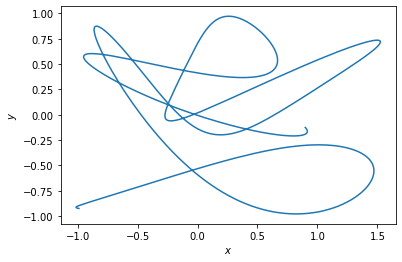

In [5]:
plt.figure()
plt.plot(an_pos[0, :, 0], an_pos[0, :, 1])
plt.ylabel(r'$y$')
plt.xlabel(r'$x$')
plt.show()

In [6]:
N_x = 6
N_y = 6

mu, prec, rate_0 = [], [], []
for nx in range(N_x):
    for ny in range(N_y):
        mu.append([nx * 6 / (N_x - 1) - 3., ny * 6 / (N_y - 1) - 3.])
        prec.append([1., 1., 0.0])
        rate_0.append(20.)  # Hz
        
mu, prec, rate_0 = np.array(mu), np.array(prec), np.array(rate_0)
w = gaussian_2D_to_w(mu, prec, rate_0)

neurons = rate_0.shape[0]

rates_t = quadratic_2D_GLM(an_pos, w, np.exp)
rates_t = rates_t.transpose(0, 2, 1)

In [7]:
cc = np.meshgrid(np.linspace(-3., 3., 30), np.linspace(-3., 3., 30))
pos_grid = np.stack(cc, axis=-1)

maps = quadratic_2D_GLM(pos_grid, w, np.exp)

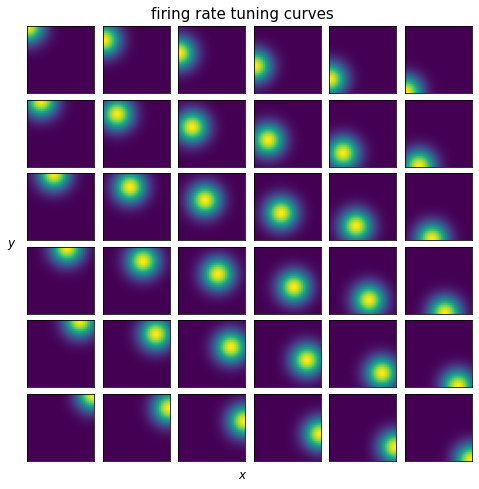

In [122]:
# show fits
grid_size = (50, 40)
grid_shape = [[-3., 3.], [-3., 3.]]

show_neurons = np.arange(36)

fig = plt.figure(figsize=(8, 8), facecolor='white')
nrows = 6
ncols = 6
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for m, neuron in enumerate(show_neurons):
        
    im = axes[m].imshow(maps[..., m])
    axes[m].set_xticks([])
    axes[m].set_yticks([])

fig.text(0.5, 0.9, 'firing rate tuning curves', ha='center', va='center', fontsize=15)
fig.text(0.1, 0.5, r'$y$', ha='center', va='center', fontsize=12)
fig.text(0.5, 0.1, r'$x$', ha='center', va='center', fontsize=12)

fig.subplots_adjust(hspace=0.1, wspace=0.1)


plt.show()

In [9]:
# generate spike counts
cnts = rng.poisson(rates_t*tbin)

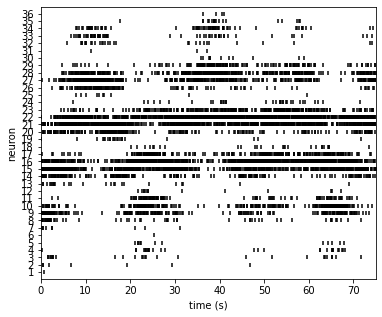

In [10]:
tr = 0

fig, ax = plt.subplots(figsize=(6,5))
raster_plot((fig, ax), cnts[tr], Tl, tbin, neurons, markersize=10)
ax.set_xlabel('time (s)')
ax.set_ylabel('neuron')
plt.show()

<a id="fit"></a>
## 2. Fit GPLVM model

$R^2$ latent space.

In [54]:
def align_CCA(X, X_tar):
    """
    :param np.array X: input variables of shape (time, dimensions)
    """
    d = X.shape[-1]
    cca = CCA(n_components=d)
    cca.fit(X, X_tar)
    X_c = cca.transform(X)
    return X_c, cca


def align_affine_2D(lats, target, scales_arr, dev='cpu', iters=20000, lr=1e-2):
    """
    Align 2D latent space through affine (rotation and scaling and translation) transform.
    Assumes the input latents are roughly unit normal distributed.
    """
    rx_t = target[0]
    ry_t = target[1]
    
    class rot_W(nn.Module):
        def __init__(self, theta=0.0):
            super().__init__()
            self.theta = nn.Parameter(torch.tensor(theta))

        def W(self):
            """ 
            assemble rotation matrix.
            """
            C = torch.cos(self.theta)[None]
            S = torch.sin(self.theta)[None]
            top = torch.cat((C, -S))
            down = torch.cat((S, C))
            return torch.cat((top[None], down[None]), dim=0)
    
    lowest_loss = np.inf

    lats = torch.tensor(lats, device=dev)
    x_tar = torch.tensor(target, device=dev)
    for scales in scales_arr: # try out different reflections, makes optimization more robust

        scales = nn.Parameter(scales)
        bias = nn.Parameter(lats.mean(-1)*torch.ones(2, device=dev))
        T = rot_W().to(dev)

        optimizer = optim.Adam(list(T.parameters()) + [scales, bias], lr=lr)

        losses = []
        for k in range(iters):
            optimizer.zero_grad()
            lats_ = scales[:, None]*(T.W() @ lats + bias[:, None])
            loss = ((x_tar-lats_)**2).mean()
            loss.backward()
            optimizer.step()
            losses.append(loss.cpu().item())

        l_ = loss.cpu().item()
        
        if l_ < lowest_loss:
            lowest_loss = l_
            W_ = T.W().data.cpu().numpy()
            bias_ = bias.data.cpu().numpy()
            scale_ = scales.data.cpu().numpy()
            losses_ = losses

    return W_, bias_, scale_, losses_

In [46]:
# latent GP prior
base_d = 2


# kernel
l = 5.*torch.ones(1, base_d)
v = torch.ones(base_d)

krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
krn_2 = nprb.kernels.Exponential(
    input_dims=l.shape[0], lengthscale=l, \
    track_dims=[0], f='softplus', \
    tensor_type=torch.float
)

kernel = nprb.kernels.Product(krn_1, krn_2)

# inducing points
num_induc = 64
Xu = np.array(
    [np.linspace(0, Tl*tbin, num_induc)]).T[None, ...].repeat(base_d, axis=0)

inducing_points = nprb.mappings.inducing_points(base_d, torch.from_numpy(Xu))

# mapping
in_dims = Xu.shape[-1]
latent_gp = nprb.mappings.SVGP(
    in_dims, base_d, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-5, mean=torch.zeros(base_d), learn_mean=True
)

# inputs
input_data = [torch.arange(Tl)*tbin]
input_group = nprb.inputs.input_group()
input_group.set_XZ(input_data, Tl, batch_info=500, trials=trials)


### assemble ###
gp_prior = nprb.inputs.probabilistic_mapping(input_group, latent_gp)

In [48]:
# kernel
l = 5.*torch.ones(2, neurons)
v = torch.ones(neurons)

krn_1 = nprb.kernels.Constant(variance=v, tensor_type=torch.float)
krn_2 = nprb.kernels.SquaredExponential(
    input_dims=len(l), lengthscale=l, \
    track_dims=[0, 1], topology='euclid', f='softplus', \
    tensor_type=torch.float
)

kernel = nprb.kernels.Product(krn_1, krn_2)

# inducing points
num_induc = 8
Xu = np.array([
    np.random.randn(num_induc), 
    np.random.randn(num_induc), 
]).T[None, ...].repeat(neurons, axis=0)
inducing_points = nprb.mappings.inducing_points(neurons, torch.from_numpy(Xu))

# inputs
input_data = [gp_prior]
input_group = nprb.inputs.input_group()
input_group.set_XZ(input_data, Tl, batch_info=500, trials=trials)

# mapping
in_dims = Xu.shape[-1]
gp = nprb.mappings.SVGP(
    in_dims, neurons, kernel, inducing_points=inducing_points, 
    whiten=True, jitter=1e-5, mean=torch.zeros(neurons), learn_mean=True
)


#likelihood = mdl.likelihoods.Gaussian(neurons, 'exp', log_var=np.zeros(neurons))
likelihood = nprb.likelihoods.discrete.Poisson(tbin, neurons, 'exp')
#likelihood = mdl.likelihoods.ZI_Poisson(tbin, neurons, 'exp', 0.0*np.zeros(neurons))
likelihood.set_Y(torch.from_numpy(cnts), batch_info=500) 


# assemble
gplvm = nprb.inference.VI_optimized(input_group, gp, likelihood)
gplvm.to(dev)

VI_optimized(
  (input_group): input_group(
    (input_0): probabilistic_mapping(
      (mapping): SVGP(
        (kernel): Product(
          (kern0): Constant()
          (kern1): Exponential()
        )
        (induc_pts): inducing_points()
      )
      (input_group): input_group()
    )
  )
  (mapping): SVGP(
    (kernel): Product(
      (kern0): Constant()
      (kern1): SquaredExponential()
    )
    (induc_pts): inducing_points()
  )
  (likelihood): Poisson()
)

In [49]:
# fitting
sch = lambda o: optim.lr_scheduler.MultiplicativeLR(o, lambda e: 0.9)
opt_tuple = (optim.Adam, 100, sch)
opt_lr_dict = {
    'default': 5*1e-3, 
    #'inputs.lv_std_0': 1e-3,  
}

gplvm.set_optimizers(opt_tuple, opt_lr_dict)

annealing = lambda x: 1.0#min(1.0, 0.005*x)
losses = gplvm.fit(
    3000, loss_margin=0.0, margin_epochs=100, kl_anneal_func=annealing, 
    cov_samples=1, ll_samples=10, ll_mode='MC', 
)

  0%|          | 0/3000 [00:00<?, ?it/s]


Stopped at epoch 1208.


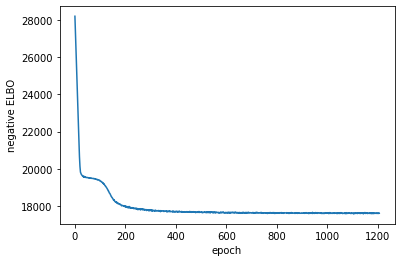

In [50]:
plt.figure()
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('negative ELBO')
plt.show()

<a id='latent'></a>
## 3. Evaluate latent space

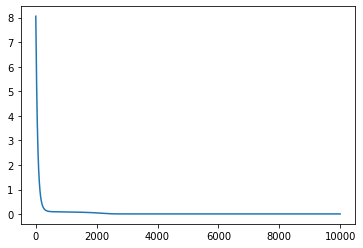

In [59]:
covariates = np.arange(Tl)*tbin

lat_mean, lat_var = gp_prior.mapping.compute_F(torch.tensor(covariates[None, None, :, None]).float().to(dev))

lat_mean = lat_mean.data.cpu().numpy()[0]
lat_var = lat_var.data.cpu().numpy()[0]
rcov = an_pos[0].T

# align
x_std, y_std = rcov[0].std(), rcov[1].std()
scales_arr = [
    torch.tensor([x_std*2, y_std*2], device=dev), 
    torch.tensor([-x_std*2, y_std*2], device=dev), 
    torch.tensor([x_std*2, -y_std*2], device=dev), 
    torch.tensor([-x_std*2, y_std*2], device=dev), 
]# take into account reflections

W_, bias_, scale_, losses_ = align_affine_2D(lat_mean, rcov, scales_arr, dev=dev, iters=10000, lr=5*1e-3)

plt.plot(losses_[:])
plt.show()

In [67]:
post_mean = scale_[:, None]*(W_ @ lat_mean + bias_[:, None])
post_std = np.sqrt(scale_[:, None]**2 *((W_**2).T @ lat_var))

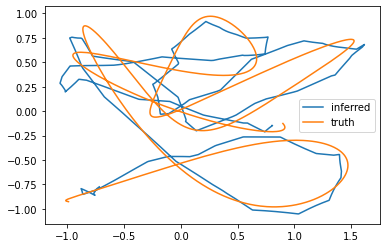

In [79]:
plt.plot(post_mean[0, :], post_mean[1, :], label='inferred')
plt.plot(rcov[0, :], rcov[1, :], label='truth')
plt.legend()
plt.show()

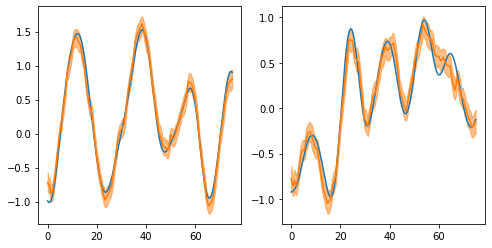

In [80]:
TT = Tl
tx = np.arange(TT)*tbin

fig, axes = plt.subplots(1, 2, figsize=(8, 4))

for k in range(2):
    axes[k].plot(tx, rcov[k][:TT])

    line, = axes[k].plot(tx, post_mean[k][:TT])
    axes[k].fill_between(
        tx, post_mean[k][:TT]-post_std[k][:TT],
        post_mean[k][:TT]+post_std[k][:TT], color=line.get_color(), alpha=0.5
    )

<a id='tuning'></a>
## 4. Evaluate tuning curves

In [81]:
def posterior_rate(mapping, likelihood, covariates, MC, F_dims, trials=1, percentiles=[0.05, .5, 0.95]):
    """
    Sample F from diagonalized variational posterior.
    
    :returns: F of shape (MCxtrials, outdims, time)
    """
    cov = mapping.to_XZ(covariates, trials)
    with torch.no_grad():
        if mapping.MC_only:
            F = mapping.sample_F(cov)[:, F_dims, :] # TODO: cov_samples vs ll_samples?
            samples = likelihood.f(F.view(-1, trials, *samples.shape[1:]))
        else:
            F_mu, F_var = mapping.compute_F(cov)
            samples = likelihood.sample_rate(
                F_mu[:, F_dims, :], F_var[:, F_dims, :], trials, MC)
    
    return utils.signal.percentiles_from_samples(samples, percentiles)

In [92]:
show_neurons = np.arange(neurons)

# sample functions
x_2D = np.meshgrid(np.linspace(-3., 3., 40), np.linspace(-3., 3., 40))
x_2D = np.stack(x_2D, axis=-1).reshape(-1, 2)

# transform the latent space according to alignment for plotting
x_2D_transf = np.linalg.inv(W_) @ (x_2D.T / scale_[:, None] - bias_[:, None])

mean, = posterior_rate(
    gp, likelihood, torch.from_numpy(x_2D_transf), 1000, show_neurons, percentiles=[.5])

mean = mean[0].reshape(-1, 40, 40).cpu().numpy()

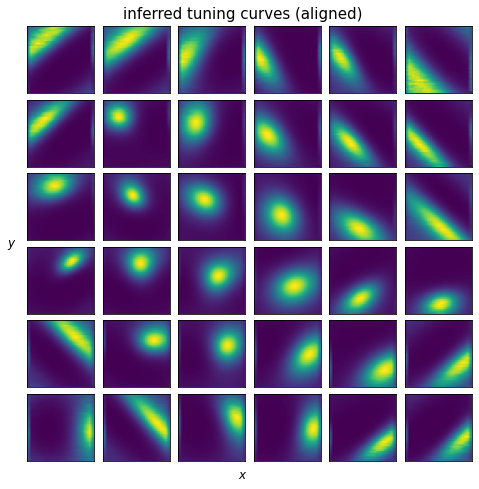

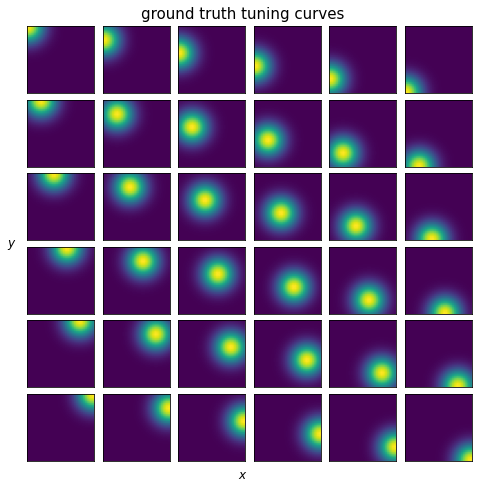

In [126]:
# show fits
grid_size = (50, 40)
grid_shape = [[-3., 3.], [-3., 3.]]

show_neurons = np.arange(36)

fig = plt.figure(figsize=(8, 8), facecolor='white')
nrows = 6
ncols = 6
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for m, neuron in enumerate(show_neurons):
        
    im = axes[m].imshow(mean[m])
    axes[m].set_xticks([])
    axes[m].set_yticks([])

fig.text(0.5, 0.9, 'inferred tuning curves (aligned)', ha='center', va='center', fontsize=15)
fig.text(0.1, 0.5, r'$y$', ha='center', va='center', fontsize=12)
fig.text(0.5, 0.1, r'$x$', ha='center', va='center', fontsize=12)

fig.subplots_adjust(hspace=0.1, wspace=0.1)

plt.show()



# show fits
grid_size = (50, 40)
grid_shape = [[-3., 3.], [-3., 3.]]

show_neurons = np.arange(36)

fig = plt.figure(figsize=(8, 8), facecolor='white')
nrows = 6
ncols = 6
axes = [ fig.add_subplot(nrows, ncols, r * ncols + c + 1) for r in range(0, nrows) for c in range(0, ncols) ]

for m, neuron in enumerate(show_neurons):
        
    im = axes[m].imshow(maps[..., m])
    axes[m].set_xticks([])
    axes[m].set_yticks([])

fig.text(0.5, 0.9, 'ground truth tuning curves', ha='center', va='center', fontsize=15)
fig.text(0.1, 0.5, r'$y$', ha='center', va='center', fontsize=12)
fig.text(0.5, 0.1, r'$x$', ha='center', va='center', fontsize=12)

fig.subplots_adjust(hspace=0.1, wspace=0.1)



plt.show()

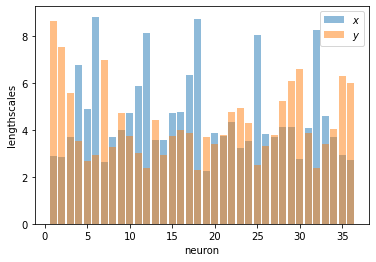

In [102]:
plt.bar(np.arange(neurons) + 1, gplvm.mapping.kernel.kern1.lengthscale.data.cpu().numpy()[0, :, 0, 0], 
        alpha=0.5, label=r'$x$')
plt.bar(np.arange(neurons) + 1, gplvm.mapping.kernel.kern1.lengthscale.data.cpu().numpy()[0, :, 0, 1], 
        alpha=0.5, label=r'$y$')
plt.ylabel('lengthscales')
plt.xlabel('neuron')
plt.legend()

plt.show()